## Import Library yang Dibutuhkan

Langkah pertama dalam proyek ini adalah mengimpor berbagai library yang dibutuhkan untuk:
- Pemrosesan data (`pandas`, `numpy`)
- Pembagian data dan modeling (`train_test_split`, `SVR`, `RandomForestRegressor`, `xgboost`)
- Evaluasi model (`mean_absolute_error`, `mean_squared_error`, `r2_score`)
- Penyimpanan model (`joblib`)
- Visualisasi data dan hasil (`matplotlib`)

In [116]:
# Impor library untuk manipulasi dan analisis data
import pandas as pd
import numpy as np

# Impor library untuk pembagian data dan model machine learning
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR  # SVR adalah implementasi Support Vector Machine untuk regresi
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb  # Pastikan xgboost sudah terinstal: pip install xgboost

# Impor library untuk evaluasi performa model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Impor library tambahan untuk penyimpanan model dan visualisasi
import joblib  # Untuk menyimpan model dalam file
import os
import matplotlib.pyplot as plt  # Untuk membuat visualisasi grafik

## Load Dataset

In [117]:
# Load dataset dari Google Drive
df = pd.read_csv('dataset/data-clean/data_scaled.csv')

# Tampilkan dimensi dataset
print(f"Shape dataset: {df.shape}")

Shape dataset: (20160, 6)


In [118]:
# Tampilkan informasi umum dari dataset
print("Info dataset")
df.info()

Info dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20160 entries, 0 to 20159
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   timestamp    20160 non-null  object 
 1   co2          20160 non-null  float64
 2   temperature  20160 non-null  float64
 3   humidity     20160 non-null  float64
 4   rainfall     20160 non-null  float64
 5   pyrano       20160 non-null  float64
dtypes: float64(5), object(1)
memory usage: 945.1+ KB


## Penyesuaian Timestamp dan Index

Pada tahap ini, kita akan:
1. Menyalin kembali data dari `df_original` untuk memastikan dataframe utama tidak dimodifikasi secara tidak sengaja.
2. Mengonversi kolom `timestamp` ke format datetime.
3. Menjadikan kolom `timestamp` sebagai index dataframe untuk memudahkan analisis deret waktu (time series).
4. Menampilkan preview data dan informasi struktur dataframe.
5. Visualisasi Data Awal

In [119]:
# Salin dataframe untuk menjaga agar data asli tidak termodifikasi
df_original = df.copy()

In [120]:
# Mengubah kolom 'timestamp' menjadi format datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [121]:
# Menjadikan 'timestamp' sebagai index dataframe
df = df.set_index('timestamp')

In [122]:
# Tampilkan 5 baris pertama dari data setelah di-set index
print("Data awal (5 baris pertama):")
display(df.head())

Data awal (5 baris pertama):


,co2,temperature,humidity,rainfall,pyrano
timestamp,,,,,
2025-04-24 00:00:00,0.470899,0.084535,1.0,0.0,0.0
2025-04-24 00:01:00,0.470899,0.084535,1.0,0.0,0.0
2025-04-24 00:02:00,0.470899,0.084535,1.0,0.0,0.0
2025-04-24 00:03:00,0.470899,0.084535,1.0,0.0,0.0
2025-04-24 00:04:00,0.470899,0.085190,1.0,0.0,0.0


In [123]:
# Tampilkan informasi struktur dataframe
print("\nInformasi DataFrame:")
display(df.info())


Informasi DataFrame:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20160 entries, 2025-04-24 00:00:00 to 2025-05-07 23:59:00
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   co2          20160 non-null  float64
 1   temperature  20160 non-null  float64
 2   humidity     20160 non-null  float64
 3   rainfall     20160 non-null  float64
 4   pyrano       20160 non-null  float64
dtypes: float64(5)
memory usage: 945.0 KB


None

VISUALISASI DATA AWAL


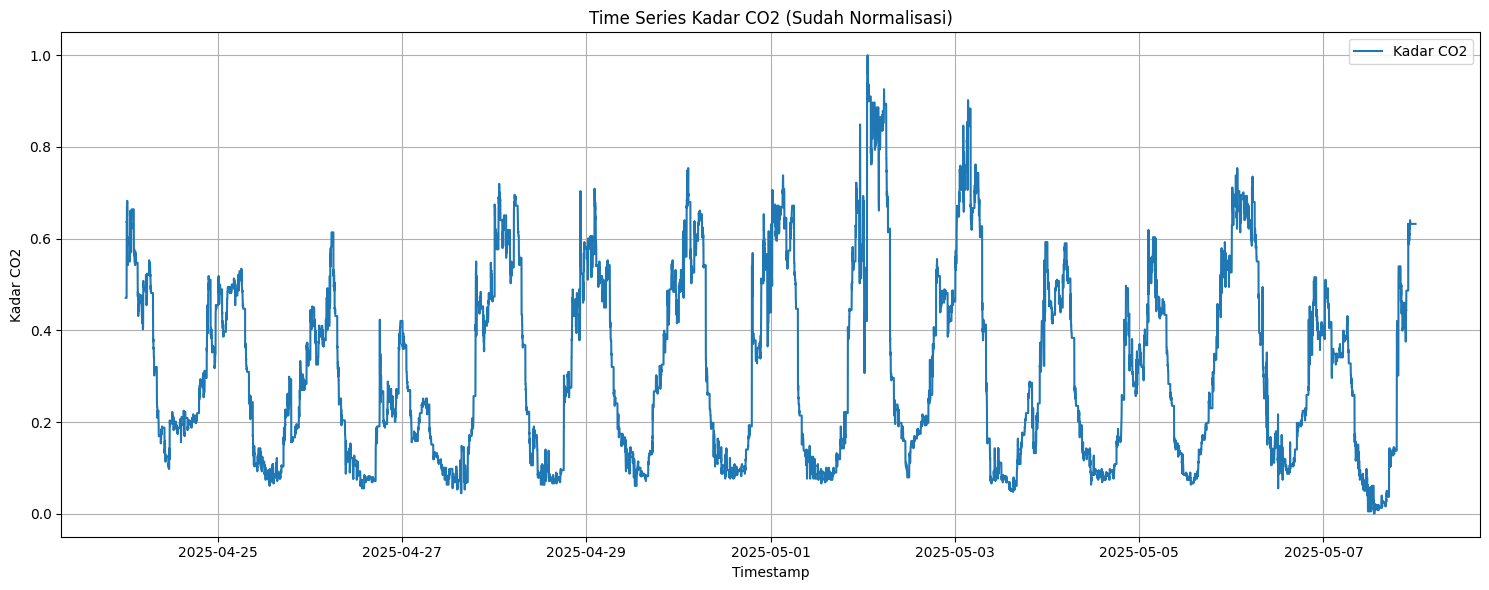

In [124]:
print("VISUALISASI DATA AWAL")
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['co2'], label='Kadar CO2')
plt.title('Time Series Kadar CO2 (Sudah Normalisasi)')
plt.xlabel('Timestamp')
plt.ylabel('Kadar CO2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Feature Enginering

Pada tahap ini, kita melakukan ini untuk membantu model memahami pola historis dan pengaruh variabel eksternal terhadap emisi karbon (`co2`). Berikut proses yang dilakukan:

- **Target prediction**:
  - `co2_target_1min`: memprediksi CO₂ 1 menit ke depan.
  - `co2_target_1hour`: memprediksi CO₂ 1 jam ke depan.
- **Fitur lag**: membuat 10 lag dari nilai CO₂ sebelumnya sebagai input ke model.
- **Fitur eksogen**: variabel cuaca seperti `temperature`, `humidity`, `rainfall`, dan `pyrano`.

Setelah fitur dibuat, dilakukan pembersihan data dengan menghapus baris yang memiliki nilai `NaN` akibat pergeseran (`shift`).

In [125]:
# Definisikan kolom target dan fitur eksogen
target_column = 'co2'
exog_features = ['temperature', 'humidity', 'rainfall', 'pyrano']

# Buat target prediksi: 1 menit ke depan dan 1 jam ke depan
df['co2_target_1min'] = df[target_column].shift(-1)
df['co2_target_1hour'] = df[target_column].shift(-60)

In [126]:
# Buat fitur lag (CO2 sebelumnya)
n_lags = 10
lag_cols = []

for i in range(1, n_lags + 1):
    col_name = f'{target_column}_lag_{i}'
    df[col_name] = df[target_column].shift(i)
    lag_cols.append(col_name)

# Gabungkan fitur lag dan fitur eksogen
feature_columns = lag_cols + exog_features
print(f"\nKolom fitur yang akan digunakan: {feature_columns}")


Kolom fitur yang akan digunakan: ['co2_lag_1', 'co2_lag_2', 'co2_lag_3', 'co2_lag_4', 'co2_lag_5', 'co2_lag_6', 'co2_lag_7', 'co2_lag_8', 'co2_lag_9', 'co2_lag_10', 'temperature', 'humidity', 'rainfall', 'pyrano']


In [127]:
# Siapkan data untuk model prediksi 1 menit
df_1min = df.dropna(subset=['co2_target_1min'] + feature_columns).copy()
X_1min_all = df_1min[feature_columns]
y_1min_all = df_1min['co2_target_1min']

In [128]:
# Siapkan data untuk model prediksi 1 jam
df_1hour = df.dropna(subset=['co2_target_1hour'] + feature_columns).copy()
X_1hour_all = df_1hour[feature_columns]
y_1hour_all = df_1hour['co2_target_1hour']

In [129]:
# Tampilkan informasi dimensi hasil feature enginering
print(f"\nJumlah data setelah feature enginering (1 menit): {len(df_1min)}")
print(f"Shape X_1min_all: {X_1min_all.shape}, Shape y_1min_all: {y_1min_all.shape}")

print(f"Jumlah data setelah feature enginering (1 jam): {len(df_1hour)}")
print(f"Shape X_1hour_all: {X_1hour_all.shape}, Shape y_1hour_all: {y_1hour_all.shape}")


Jumlah data setelah feature enginering (1 menit): 20149
Shape X_1min_all: (20149, 14), Shape y_1min_all: (20149,)
Jumlah data setelah feature enginering (1 jam): 20090
Shape X_1hour_all: (20090, 14), Shape y_1hour_all: (20090,)


In [130]:
# Validasi ketersediaan data
if X_1min_all.empty or X_1hour_all.empty:
    print("Error: Tidak ada data tersisa setelah rekayasa fitur.")
    exit()

## Pembagian Data untuk Evaluasi

Agar model bisa diuji performanya dengan adil, dataset dibagi menjadi **data latih (train)** dan **data uji (test)**.

- Proporsi pembagian adalah 80% data latih dan 20% data uji.
- `shuffle=False` digunakan karena ini adalah data time series, sehingga urutan waktu harus dipertahankan.

Pembagian ini dilakukan untuk dua skenario prediksi:
- Prediksi 1 menit ke depan (`1min`)
- Prediksi 1 jam ke depan (`1hour`)

In [131]:
# Pembagian data untuk model prediksi 1 menit ke depan
X_train_1min, X_test_1min, y_train_1min, y_test_1min = train_test_split(
    X_1min_all, y_1min_all, test_size=0.2, shuffle=False
)

print(f"Jumlah data latih (1 menit): {len(X_train_1min)}")
print(f"Jumlah data uji   (1 menit): {len(X_test_1min)}")

Jumlah data latih (1 menit): 16119
Jumlah data uji   (1 menit): 4030


In [132]:
# Pembagian data untuk model prediksi 1 jam ke depan
X_train_1hour, X_test_1hour, y_train_1hour, y_test_1hour = train_test_split(
    X_1hour_all, y_1hour_all, test_size=0.2, shuffle=False
)

print(f"Jumlah data latih (1 jam): {len(X_train_1hour)}")
print(f"Jumlah data uji   (1 jam): {len(X_test_1hour)}")

Jumlah data latih (1 jam): 16072
Jumlah data uji   (1 jam): 4018


## Pelatihan, Evaluasi, dan Visualisasi Model

Pada langkah ini, kita akan:
- Melatih beberapa model regresi (SVM, Random Forest, XGBoost)
- Mengevaluasi kinerjanya dengan metrik: MAE, MSE, RMSE, dan R²
- Visualisasi hasil prediksi vs data aktual

Langkah ini dilakukan untuk horizon prediksi **1 menit dan 1 jam ke depan**.

In [133]:
# Menyiapkan storage untuk hasil evaluasi dan model hasil training
evaluation_results_storage = {"1_min": {}, "1_hour": {}}
trained_models_storage = {"1_min": {}, "1_hour": {}}

# Fungsi untuk mem-plot nilai aktual vs hasil prediksi dari model
def plot_actual_vs_predicted(y_true, y_pred, model_name, horizon_tag, test_index):
    plt.figure(figsize=(15, 6))
    plt.plot(test_index, y_true, label='Nilai Aktual CO2 (Test Set)', color='blue')
    plt.plot(test_index, y_pred, label=f'Prediksi {model_name} (Test Set)', color='red', linestyle='--')
    plt.title(f'Perbandingan Aktual vs Prediksi ({model_name}) - {horizon_tag}')
    plt.xlabel('Timestamp')
    plt.ylabel('Kadar CO2 (Scaled)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Prediksi 1 menit Ke Depan

### Inisiasi untuk prediksi 1 menit

In [134]:
horizon_tag_1min = "1 Menit"

### Model 1: SVM Regressor - Prediksi 1 Menit ke Depan

Model: SVM Regressor (1 Menit)
Melatih SVM Regressor
Mengevaluasi SVM Regressor
Hasil Evaluasi SVM Regressor (1 Menit):
MAE: 0.0509, MSE: 0.0047, RMSE: 0.0689, R2 Score: 0.8845


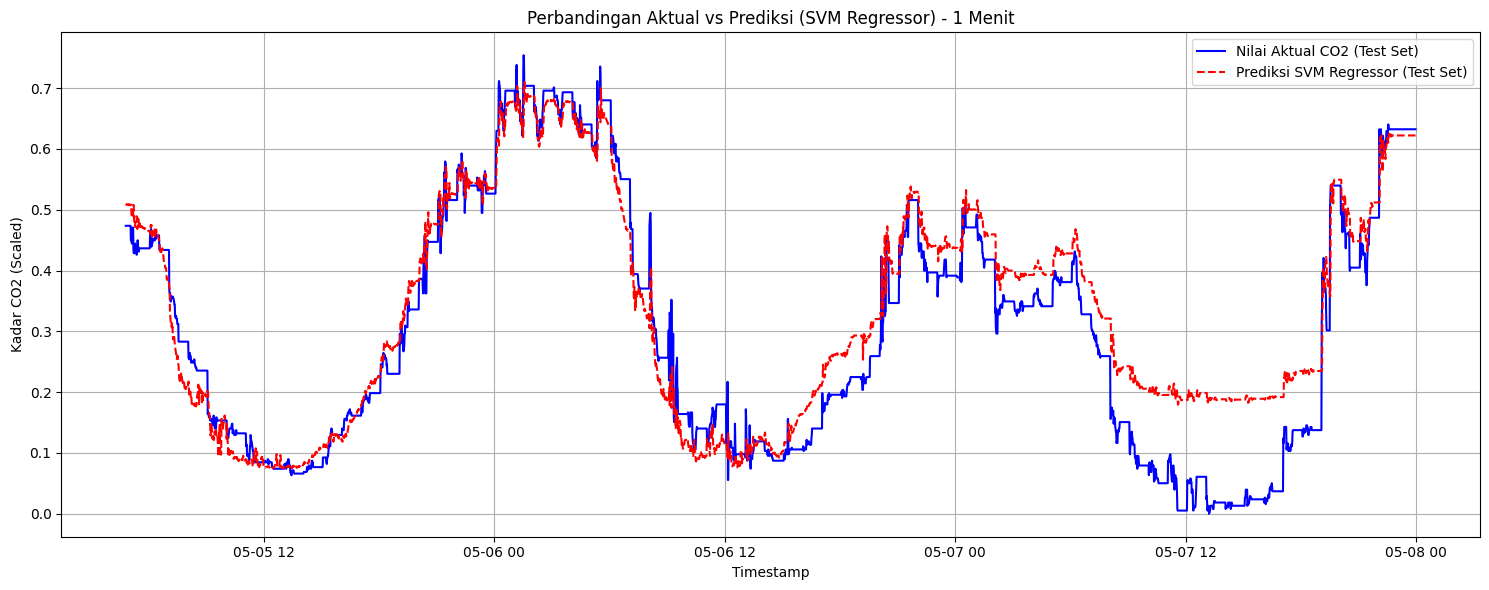

In [135]:
# --- Model SVM Regressor ---
model_name_svm = "SVM Regressor"
print(f"Model: {model_name_svm} ({horizon_tag_1min})")

# Inisialisasi model SVM dengan kernel RBF
svm_model_1min = SVR(kernel='rbf')

# Melatih model pada data training
print(f"Melatih {model_name_svm}")
svm_model_1min.fit(X_train_1min, y_train_1min)

# Simpan model terlatih
trained_models_storage["1_min"][model_name_svm] = svm_model_1min

# Prediksi pada data test
print(f"Mengevaluasi {model_name_svm}")
predictions_svm_1min = svm_model_1min.predict(X_test_1min)

# Hitung metrik evaluasi
mae_svm_1min = mean_absolute_error(y_test_1min, predictions_svm_1min)
mse_svm_1min = mean_squared_error(y_test_1min, predictions_svm_1min)
rmse_svm_1min = np.sqrt(mse_svm_1min)
r2_svm_1min = r2_score(y_test_1min, predictions_svm_1min)

# Simpan hasil evaluasi
evaluation_results_storage["1_min"][model_name_svm] = {
    "MAE": mae_svm_1min, "MSE": mse_svm_1min, "RMSE": rmse_svm_1min, "R2": r2_svm_1min
}

# Cetak hasil evaluasi
print(f"Hasil Evaluasi {model_name_svm} ({horizon_tag_1min}):")
print(f"MAE: {mae_svm_1min:.4f}, MSE: {mse_svm_1min:.4f}, RMSE: {rmse_svm_1min:.4f}, R2 Score: {r2_svm_1min:.4f}")

# Visualisasi hasil prediksi vs aktual
plot_actual_vs_predicted(y_test_1min, predictions_svm_1min, model_name_svm, horizon_tag_1min, X_test_1min.index)

### Model 2: Random Forest - Prediksi 1 Menit ke Depan

Model: RandomForest (1 Menit)
Melatih RandomForest
Mengevaluasi RandomForest
Hasil Evaluasi RandomForest (1 Menit):
MAE: 0.0225, MSE: 0.0014, RMSE: 0.0381, R2 Score: 0.9647


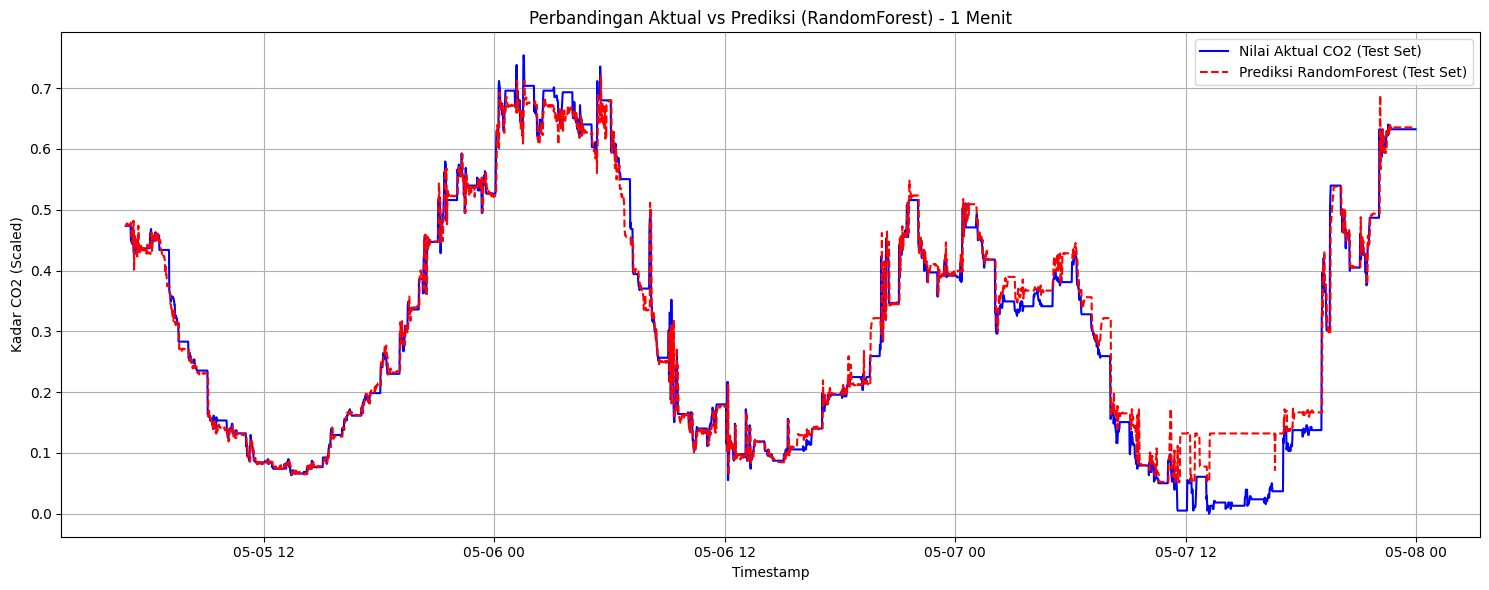

In [136]:
# --- Model Random Forest ---
model_name_rf = "RandomForest"
print(f"Model: {model_name_rf} ({horizon_tag_1min})")

# Inisialisasi model Random Forest
rf_model_1min = RandomForestRegressor(random_state=42, n_estimators=100)

# Melatih model
print(f"Melatih {model_name_rf}")
rf_model_1min.fit(X_train_1min, y_train_1min)

# Simpan model
trained_models_storage["1_min"][model_name_rf] = rf_model_1min

# Prediksi pada data test
print(f"Mengevaluasi {model_name_rf}")
predictions_rf_1min = rf_model_1min.predict(X_test_1min)

# Evaluasi model
mae_rf_1min = mean_absolute_error(y_test_1min, predictions_rf_1min)
mse_rf_1min = mean_squared_error(y_test_1min, predictions_rf_1min)
rmse_rf_1min = np.sqrt(mse_rf_1min)
r2_rf_1min = r2_score(y_test_1min, predictions_rf_1min)

# Simpan hasil evaluasi
evaluation_results_storage["1_min"][model_name_rf] = {
    "MAE": mae_rf_1min, "MSE": mse_rf_1min, "RMSE": rmse_rf_1min, "R2": r2_rf_1min
}

# Cetak hasil evaluasi
print(f"Hasil Evaluasi {model_name_rf} ({horizon_tag_1min}):")
print(f"MAE: {mae_rf_1min:.4f}, MSE: {mse_rf_1min:.4f}, RMSE: {rmse_rf_1min:.4f}, R2 Score: {r2_rf_1min:.4f}")

# Visualisasi hasil prediksi
plot_actual_vs_predicted(y_test_1min, predictions_rf_1min, model_name_rf, horizon_tag_1min, X_test_1min.index)

### Model 3: XGBoost - Prediksi 1 Menit ke Depan

Model: XGBoost (1 Menit)
Melatih XGBoost
Mengevaluasi XGBoost
Hasil Evaluasi XGBoost (1 Menit):
MAE: 0.0271, MSE: 0.0027, RMSE: 0.0524, R2 Score: 0.9333


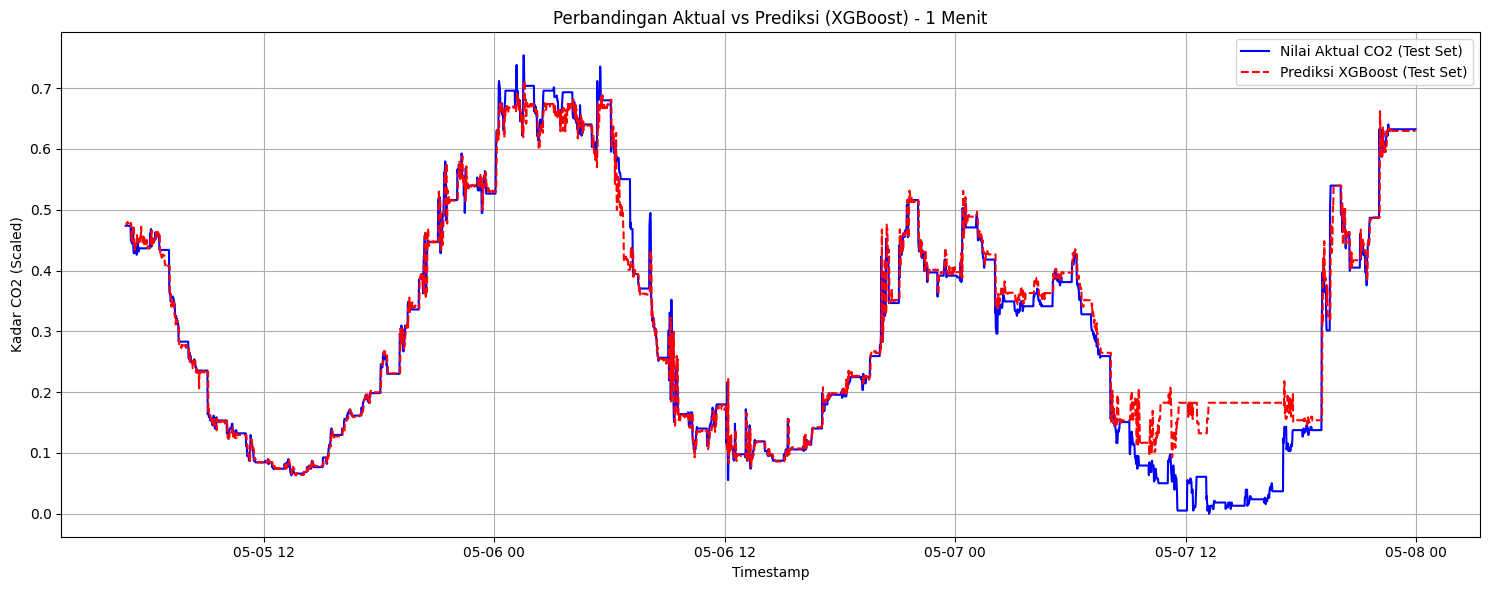

In [137]:
# --- Model XGBoost ---
model_name_xgb = "XGBoost"
print(f"Model: {model_name_xgb} ({horizon_tag_1min})")

# Inisialisasi model XGBoost Regressor
xgb_model_1min = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=100)

# Training model
print(f"Melatih {model_name_xgb}")
xgb_model_1min.fit(X_train_1min, y_train_1min)

# Simpan model
trained_models_storage["1_min"][model_name_xgb] = xgb_model_1min

# Prediksi data test
print(f"Mengevaluasi {model_name_xgb}")
predictions_xgb_1min = xgb_model_1min.predict(X_test_1min)

# Evaluasi performa
mae_xgb_1min = mean_absolute_error(y_test_1min, predictions_xgb_1min)
mse_xgb_1min = mean_squared_error(y_test_1min, predictions_xgb_1min)
rmse_xgb_1min = np.sqrt(mse_xgb_1min)
r2_xgb_1min = r2_score(y_test_1min, predictions_xgb_1min)

# Simpan hasil evaluasi
evaluation_results_storage["1_min"][model_name_xgb] = {
    "MAE": mae_xgb_1min, "MSE": mse_xgb_1min, "RMSE": rmse_xgb_1min, "R2": r2_xgb_1min
}

# Tampilkan metrik evaluasi
print(f"Hasil Evaluasi {model_name_xgb} ({horizon_tag_1min}):")
print(f"MAE: {mae_xgb_1min:.4f}, MSE: {mse_xgb_1min:.4f}, RMSE: {rmse_xgb_1min:.4f}, R2 Score: {r2_xgb_1min:.4f}")

# Visualisasi hasil prediksi
plot_actual_vs_predicted(y_test_1min, predictions_xgb_1min, model_name_xgb, horizon_tag_1min, X_test_1min.index)

### Tabel Evaluasi Untuk Prediksi 1 Menit Ke Depan

In [138]:
# --- TABEL EVALUASI UNTUK PREDIKSI 1 MENIT KE DEPAN ---

# Ambil hasil evaluasi dari storage
eval_1min = evaluation_results_storage["1_min"]

# Konversi ke DataFrame untuk tampilan tabular
eval_df_1min = pd.DataFrame(eval_1min).T  # .T untuk transpose agar model jadi baris

# Tampilkan tabel
display(eval_df_1min.style.format({
    "MAE": "{:.4f}",
    "MSE": "{:.4f}",
    "RMSE": "{:.4f}",
    "R2": "{:.4f}"
}).set_caption("Evaluasi Model Prediksi CO2 - 1 Menit ke Depan"))

,MAE,MSE,RMSE,R2
SVM Regressor,0.0509,0.0047,0.0689,0.8845
RandomForest,0.0225,0.0014,0.0381,0.9647
XGBoost,0.0271,0.0027,0.0524,0.9333


## Prediksi 1 Jam Ke Depan

### Inisiasi untuk prediksi 1 jam

In [139]:
horizon_tag_1hour = "1 Jam"

### Model 1: SVM Regressor - Prediksi 1 Jam ke Depan

Model: SVM Regressor (1 Jam)
Melatih SVM Regressor
Mengevaluasi SVM Regressor
Hasil Evaluasi SVM Regressor (1 Jam):
MAE: 0.0799, MSE: 0.0111, RMSE: 0.1055, R2 Score: 0.7295


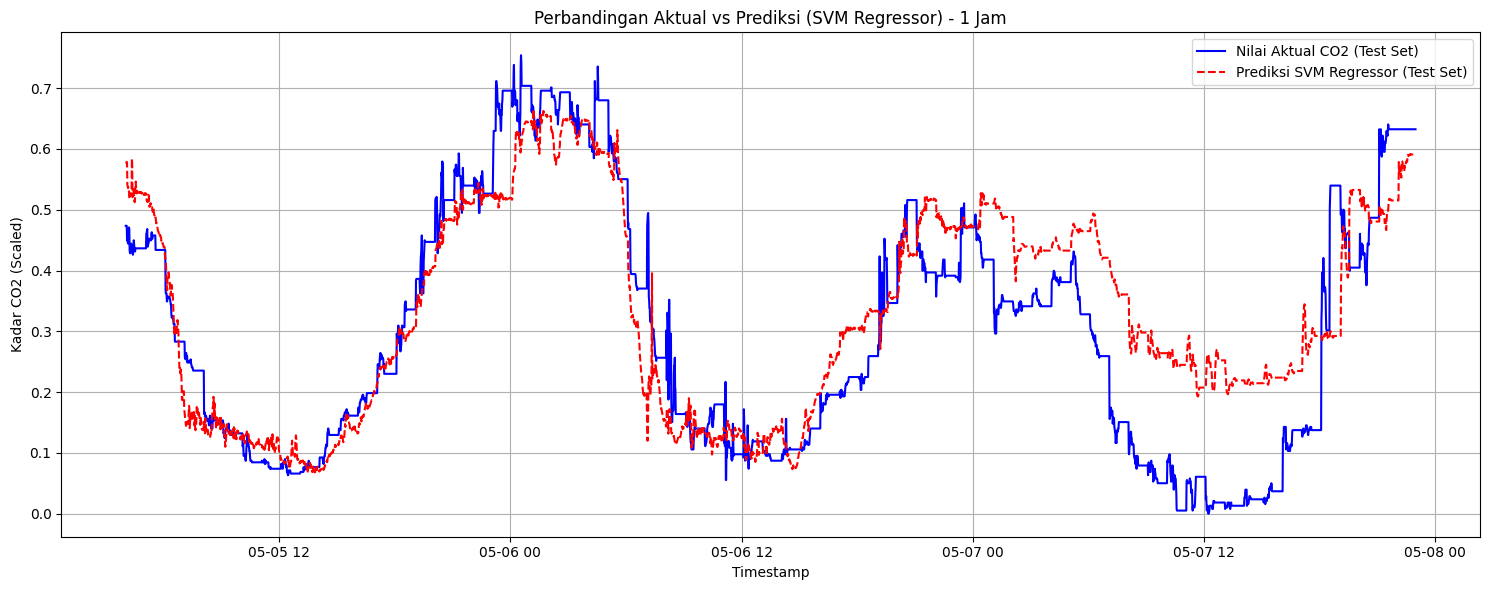

In [140]:
# --- Model: SVM Regressor (1 Jam) ---
model_name_svm = "SVM Regressor"
print(f"Model: {model_name_svm} ({horizon_tag_1hour})")

# Inisialisasi model Support Vector Regression dengan kernel RBF
svm_model_1hour = SVR(kernel='rbf')

# Melatih model menggunakan data latih
print(f"Melatih {model_name_svm}")
svm_model_1hour.fit(X_train_1hour, y_train_1hour)

# Simpan model yang sudah dilatih
trained_models_storage["1_hour"][model_name_svm] = svm_model_1hour

# Prediksi data uji
print(f"Mengevaluasi {model_name_svm}")
predictions_svm_1hour = svm_model_1hour.predict(X_test_1hour)

# Hitung metrik evaluasi
mae_svm_1hour = mean_absolute_error(y_test_1hour, predictions_svm_1hour)
mse_svm_1hour = mean_squared_error(y_test_1hour, predictions_svm_1hour)
rmse_svm_1hour = np.sqrt(mse_svm_1hour)
r2_svm_1hour = r2_score(y_test_1hour, predictions_svm_1hour)

# Simpan hasil evaluasi
evaluation_results_storage["1_hour"][model_name_svm] = {
    "MAE": mae_svm_1hour,
    "MSE": mse_svm_1hour,
    "RMSE": rmse_svm_1hour,
    "R2": r2_svm_1hour
}

# Tampilkan hasil evaluasi
print(f"Hasil Evaluasi {model_name_svm} ({horizon_tag_1hour}):")
print(f"MAE: {mae_svm_1hour:.4f}, MSE: {mse_svm_1hour:.4f}, RMSE: {rmse_svm_1hour:.4f}, R2 Score: {r2_svm_1hour:.4f}")

# Visualisasi: plot aktual vs prediksi
plot_actual_vs_predicted(
    y_test_1hour,
    predictions_svm_1hour,
    model_name_svm,
    horizon_tag_1hour,
    X_test_1hour.index
)

### Model 2: Random Forest - Prediksi 1 Jam ke Depan

Model: RandomForest (1 Jam)
Melatih RandomForest
Mengevaluasi RandomForest
Hasil Evaluasi RandomForest (1 Jam):
MAE: 0.0894, MSE: 0.0133, RMSE: 0.1154, R2 Score: 0.6763


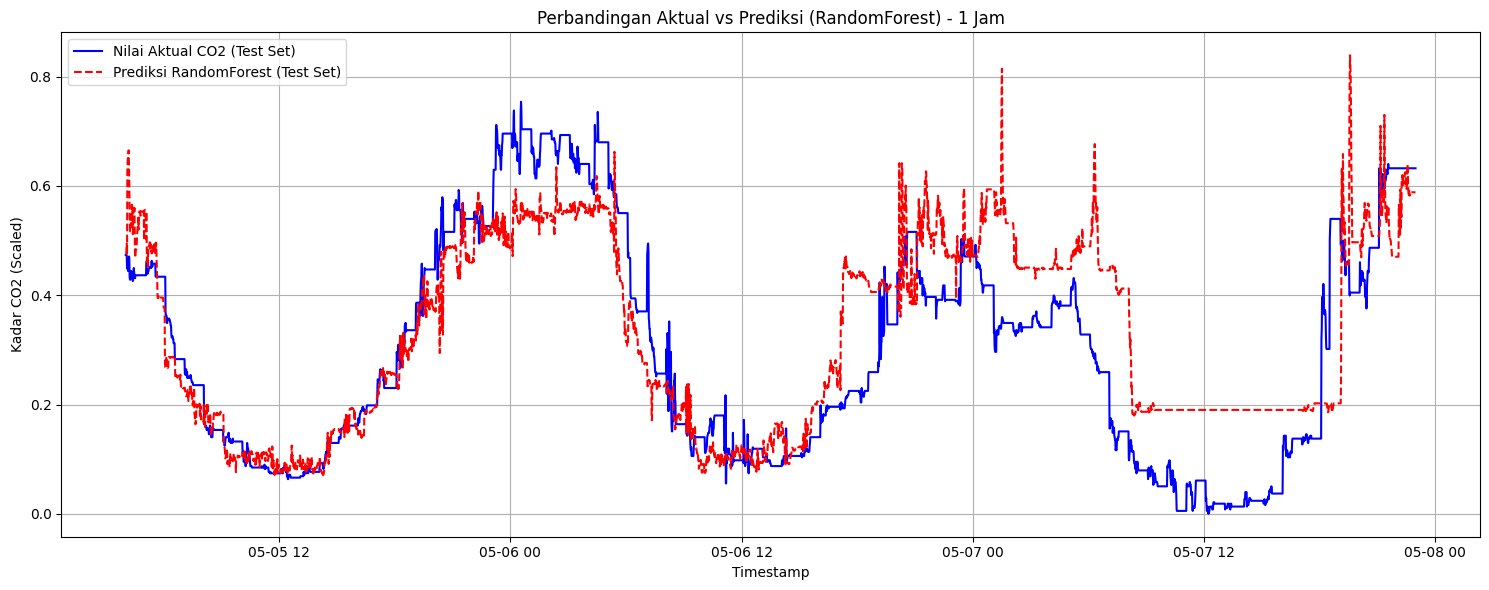

In [141]:
# --- Model: RandomForest (1 Jam) ---
model_name_rf = "RandomForest"
print(f"Model: {model_name_rf} ({horizon_tag_1hour})")

# Inisialisasi RandomForest Regressor dengan 100 pohon
rf_model_1hour = RandomForestRegressor(random_state=42, n_estimators=100)

# Melatih model
print(f"Melatih {model_name_rf}")
rf_model_1hour.fit(X_train_1hour, y_train_1hour)

# Simpan model yang sudah dilatih
trained_models_storage["1_hour"][model_name_rf] = rf_model_1hour

# Prediksi data uji
print(f"Mengevaluasi {model_name_rf}")
predictions_rf_1hour = rf_model_1hour.predict(X_test_1hour)

# Hitung metrik evaluasi
mae_rf_1hour = mean_absolute_error(y_test_1hour, predictions_rf_1hour)
mse_rf_1hour = mean_squared_error(y_test_1hour, predictions_rf_1hour)
rmse_rf_1hour = np.sqrt(mse_rf_1hour)
r2_rf_1hour = r2_score(y_test_1hour, predictions_rf_1hour)

# Simpan hasil evaluasi
evaluation_results_storage["1_hour"][model_name_rf] = {
    "MAE": mae_rf_1hour,
    "MSE": mse_rf_1hour,
    "RMSE": rmse_rf_1hour,
    "R2": r2_rf_1hour
}

# Tampilkan hasil evaluasi
print(f"Hasil Evaluasi {model_name_rf} ({horizon_tag_1hour}):")
print(f"MAE: {mae_rf_1hour:.4f}, MSE: {mse_rf_1hour:.4f}, RMSE: {rmse_rf_1hour:.4f}, R2 Score: {r2_rf_1hour:.4f}")

# Visualisasi hasil prediksi
plot_actual_vs_predicted(
    y_test_1hour,
    predictions_rf_1hour,
    model_name_rf,
    horizon_tag_1hour,
    X_test_1hour.index
)

### Model 3: XGBoost - Prediksi 1 Jam ke Depan

Model: XGBoost (1 Jam)
Melatih XGBoost
Mengevaluasi XGBoost...
Hasil Evaluasi XGBoost (1 Jam):
MAE: 0.0951, MSE: 0.0149, RMSE: 0.1222, R2 Score: 0.6368


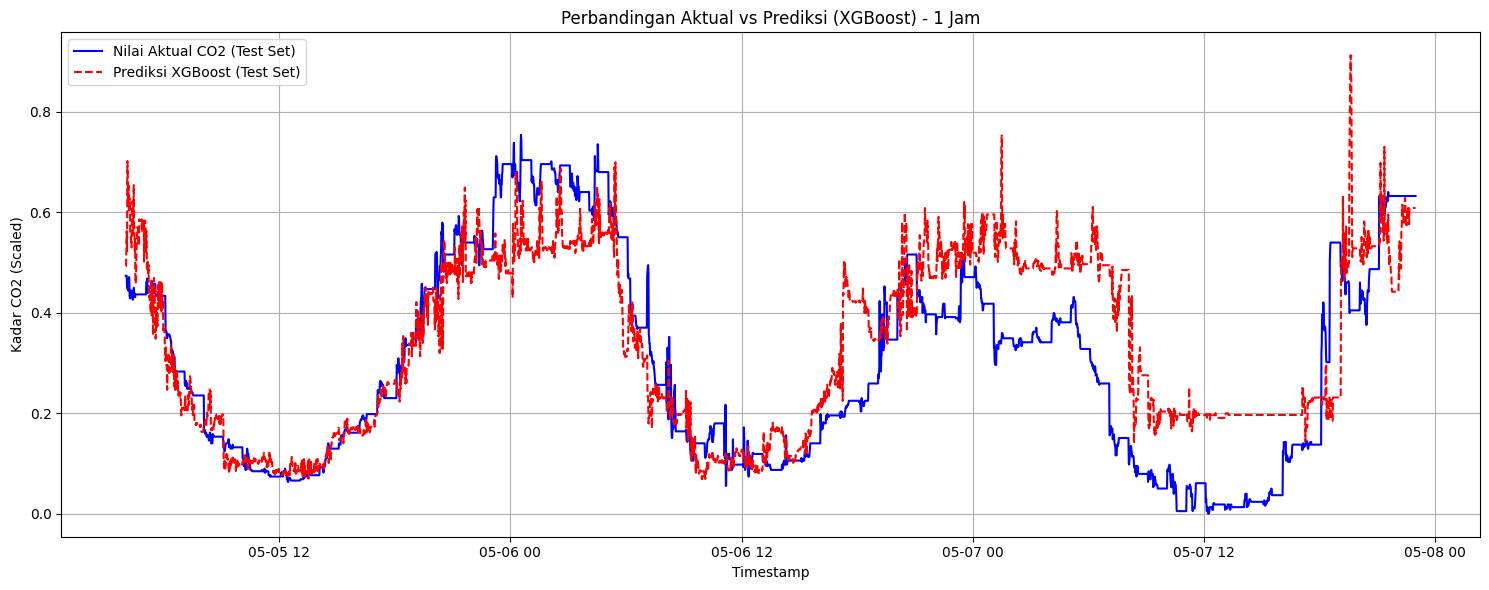

In [142]:
# --- Model: XGBoost (1 Jam) ---
model_name_xgb = "XGBoost"
print(f"Model: {model_name_xgb} ({horizon_tag_1hour})")

# Inisialisasi XGBoost Regressor dengan objective squared error
xgb_model_1hour = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=100)

# Melatih model
print(f"Melatih {model_name_xgb}")
xgb_model_1hour.fit(X_train_1hour, y_train_1hour)

# Simpan model yang sudah dilatih
trained_models_storage["1_hour"][model_name_xgb] = xgb_model_1hour

# Prediksi data uji
print(f"Mengevaluasi {model_name_xgb}...")
predictions_xgb_1hour = xgb_model_1hour.predict(X_test_1hour)

# Hitung metrik evaluasi
mae_xgb_1hour = mean_absolute_error(y_test_1hour, predictions_xgb_1hour)
mse_xgb_1hour = mean_squared_error(y_test_1hour, predictions_xgb_1hour)
rmse_xgb_1hour = np.sqrt(mse_xgb_1hour)
r2_xgb_1hour = r2_score(y_test_1hour, predictions_xgb_1hour)

# Simpan hasil evaluasi
evaluation_results_storage["1_hour"][model_name_xgb] = {
    "MAE": mae_xgb_1hour,
    "MSE": mse_xgb_1hour,
    "RMSE": rmse_xgb_1hour,
    "R2": r2_xgb_1hour
}

# Tampilkan hasil evaluasi
print(f"Hasil Evaluasi {model_name_xgb} ({horizon_tag_1hour}):")
print(f"MAE: {mae_xgb_1hour:.4f}, MSE: {mse_xgb_1hour:.4f}, RMSE: {rmse_xgb_1hour:.4f}, R2 Score: {r2_xgb_1hour:.4f}")

# Visualisasi hasil prediksi
plot_actual_vs_predicted(
    y_test_1hour,
    predictions_xgb_1hour,
    model_name_xgb,
    horizon_tag_1hour,
    X_test_1hour.index
)

### Tabel Evaluasi Untuk Prediksi 1 Jam Ke Depan

In [143]:
# --- TABEL EVALUASI UNTUK PREDIKSI 1 JAM KE DEPAN ---

# Ambil hasil evaluasi dari storage
eval_1hour = evaluation_results_storage["1_hour"]

# Konversi ke DataFrame untuk tampilan tabular
eval_df_1hour = pd.DataFrame(eval_1hour).T  # .T untuk transpose agar model jadi baris

# Tampilkan tabel
display(eval_df_1min.style.format({
    "MAE": "{:.4f}",
    "MSE": "{:.4f}",
    "RMSE": "{:.4f}",
    "R2": "{:.4f}"
}).set_caption("Evaluasi Model Prediksi CO2 - 1 Jam ke Depan"))

,MAE,MSE,RMSE,R2
SVM Regressor,0.0509,0.0047,0.0689,0.8845
RandomForest,0.0225,0.0014,0.0381,0.9647
XGBoost,0.0271,0.0027,0.0524,0.9333


## Perbandingan Model Keseluruhan

Pada tahap ini, dilakukan **perbandingan performa antar model** untuk masing-masing horizon waktu prediksi (`1 Menit` dan `1 Jam ke Depan`) berdasarkan metrik evaluasi berikut:

- **MAE (Mean Absolute Error)** – Semakin kecil, semakin baik.
- **MSE (Mean Squared Error)** – Semakin kecil, semakin baik.
- **RMSE (Root Mean Squared Error)** – Semakin kecil, semakin baik.
- **R² Score (Koefisien Determinasi)** – Semakin besar, semakin baik.

#### Tahapan dalam proses ini meliputi:
1. Menampilkan tabel evaluasi lengkap untuk setiap model.
2. Mengidentifikasi model terbaik dan terburuk untuk setiap metrik.
3. Menghitung **skor komposit** setiap model berdasarkan ranking performa pada semua metrik.
4. Menentukan **model terbaik secara keseluruhan** yang akan digunakan untuk training akhir dan prediksi masa depan.

Dengan pendekatan ini, kita tidak hanya mengandalkan satu metrik, tetapi menggunakan pendekatan multi-metrik agar pemilihan model lebih objektif dan menyeluruh.


In [144]:
# Fungsi untuk menampilkan detail evaluasi dan memilih model terbaik
def display_detailed_comparison(eval_results_dict, horizon_tag):
    # Cek apakah hasil evaluasi tersedia
    if not eval_results_dict:
        print(f"Tidak ada hasil evaluasi untuk prediksi {horizon_tag}.")
        return None

    # Konversi dictionary evaluasi ke DataFrame
    eval_df = pd.DataFrame(eval_results_dict).T

    # Tampilkan tabel performa lengkap
    print(f"\n{'-'*30} Tabel Performa Model Lengkap ({horizon_tag}) {'-'*30}")
    print(eval_df[['MAE', 'MSE', 'RMSE', 'R2']].to_string())
    print(f"{'-'* (60 + len(f' Tabel Performa Model Lengkap ({horizon_tag}) '))}")

    # Daftar metrik yang akan dianalisis
    metrics_display_order = ["MAE", "MSE", "RMSE", "R2"]

    # Konfigurasi untuk menentukan model terbaik/terburuk per metrik
    metrics_criteria = {
        "MAE": {"best_func": "idxmin", "worst_func": "idxmax", "desc": "terendah (terbaik)", "worst_desc": "tertinggi (terburuk)", "rank_ascending": True},
        "MSE": {"best_func": "idxmin", "worst_func": "idxmax", "desc": "terendah (terbaik)", "worst_desc": "tertinggi (terburuk)", "rank_ascending": True},
        "RMSE": {"best_func": "idxmin", "worst_func": "idxmax", "desc": "terendah (terbaik)", "worst_desc": "tertinggi (terburuk)", "rank_ascending": True},
        "R2": {"best_func": "idxmax", "worst_func": "idxmin", "desc": "tertinggi (terbaik)", "worst_desc": "terendah (terburuk)", "rank_ascending": False}
    }

    # Simpan ringkasan perbandingan per metrik
    summary_data = []
    for metric in metrics_display_order:
        if metric in eval_df.columns:
            funcs = metrics_criteria[metric]
            best_model_name = getattr(eval_df[metric], funcs["best_func"])()
            worst_model_name = getattr(eval_df[metric], funcs["worst_func"])()
            summary_data.append({
                "Metrik": metric,
                "Model Terbaik": best_model_name,
                "Nilai Terbaik": f"{eval_df.loc[best_model_name, metric]:.4f} ({funcs['desc']})",
                "Model Terburuk": worst_model_name,
                "Nilai Terburuk": f"{eval_df.loc[worst_model_name, metric]:.4f} ({funcs['worst_desc']})"
            })

    # Tampilkan ringkasan performa per metrik
    if summary_data:
        summary_df = pd.DataFrame(summary_data)[["Metrik", "Model Terbaik", "Nilai Terbaik", "Model Terburuk", "Nilai Terburuk"]]
        print(f"\n{'-'*25} Ringkasan Perbandingan Model ({horizon_tag}) {'-'*25}")
        print(summary_df.to_string(index=False))
        print(f"{'-'* (50 + len(f' Ringkasan Perbandingan Model ({horizon_tag}) '))}")

    # Seleksi model terbaik secara keseluruhan dengan sistem skor
    if not eval_df.empty:
        model_scores = pd.Series(0, index=eval_df.index)  # Inisialisasi skor
        num_models = len(eval_df)

        # Hitung skor per model berdasarkan peringkat tiap metrik
        for metric in metrics_display_order:
            if metric in eval_df.columns:
                ascending = metrics_criteria[metric]["rank_ascending"]
                ranks = eval_df[metric].rank(method='min', ascending=ascending)  # Semakin kecil rank semakin bagus
                scores = num_models - ranks + 1  # Rank 1 = poin tertinggi
                model_scores = model_scores.add(scores, fill_value=0)

        # Tampilkan skor gabungan model
        print(f"\nSkor Komposit Model untuk Seleksi Final ({horizon_tag}):")
        print(model_scores.sort_values(ascending=False).to_string())

        # Ambil model dengan skor tertinggi
        best_overall_model_name = model_scores.idxmax()
        print(f"\n-> Model yang akan digunakan untuk training final ({horizon_tag}) berdasarkan skor komposit tertinggi: {best_overall_model_name} (Skor: {model_scores.max()})")
        return best_overall_model_name

    return None  # Jika tidak ada data

# --- Panggil Fungsi Perbandingan untuk Masing-Masing Horizon ---

# Perbandingan model untuk prediksi 1 menit ke depan
print("\nPerbandingan Detail untuk Prediksi 1 Menit")
best_overall_model_1min_name = display_detailed_comparison(evaluation_results_storage["1_min"], "1 Menit")

# Perbandingan model untuk prediksi 1 jam ke depan
print("\n\nPerbandingan Detail untuk Prediksi 1 Jam")
best_overall_model_1hour_name = display_detailed_comparison(evaluation_results_storage["1_hour"], "1 Jam")


Perbandingan Detail untuk Prediksi 1 Menit

------------------------------ Tabel Performa Model Lengkap (1 Menit) ------------------------------
                    MAE       MSE      RMSE        R2
SVM Regressor  0.050948  0.004749  0.068915  0.884463
RandomForest   0.022472  0.001450  0.038077  0.964729
XGBoost        0.027126  0.002743  0.052376  0.933264
----------------------------------------------------------------------------------------------------

------------------------- Ringkasan Perbandingan Model (1 Menit) -------------------------
Metrik Model Terbaik                Nilai Terbaik Model Terburuk                Nilai Terburuk
   MAE  RandomForest  0.0225 (terendah (terbaik))  SVM Regressor 0.0509 (tertinggi (terburuk))
   MSE  RandomForest  0.0014 (terendah (terbaik))  SVM Regressor 0.0047 (tertinggi (terburuk))
  RMSE  RandomForest  0.0381 (terendah (terbaik))  SVM Regressor 0.0689 (tertinggi (terburuk))
    R2  RandomForest 0.9647 (tertinggi (terbaik))  SVM Regressor 

## Pelatihan Model Final Terbaik, Prediksi Masa Depan, dan Penyimpanan Model

Setelah menentukan model terbaik berdasarkan evaluasi skor komposit, langkah selanjutnya adalah:

1. **Melatih ulang model terbaik** menggunakan seluruh data pelatihan (bukan hanya train/test split).
2. **Menyimpan model final** ke dalam file `.joblib` agar dapat digunakan kembali tanpa perlu melatih ulang.


In [145]:
print("Catatan: Model terbaik (berdasarkan skor komposit) akan dilatih ulang dengan seluruh data yang relevan dan disimpan.")

model_save_dir = "saved_models"
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)
    print(f"Direktori '{model_save_dir}' telah dibuat.")

# Fungsi untuk melatih ulang dan menyimpan model final
def retrain_and_save_final_model(best_model_name_for_final_training, X_all, y_all, horizon_tag):
    if best_model_name_for_final_training is None:
        print(f"Tidak ada model terbaik yang ditentukan (berdasarkan skor komposit) untuk prediksi {horizon_tag}. Pelatihan ulang dan penyimpanan dilewati.")
        return None

    print(f"\nMelatih ulang model final ({best_model_name_for_final_training}) untuk {horizon_tag} menggunakan seluruh data yang relevan...")

    final_model_retrained = None
    # Menggunakan definisi model yang sama seperti di awal untuk konsistensi parameter
    if best_model_name_for_final_training == "SVM Regressor": final_model_retrained = SVR(kernel='rbf')
    elif best_model_name_for_final_training == "RandomForest": final_model_retrained = RandomForestRegressor(random_state=42, n_estimators=100)
    elif best_model_name_for_final_training == "XGBoost": final_model_retrained = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=100)
    else:
        print(f"Nama model terbaik '{best_model_name_for_final_training}' tidak dikenali.")
        return None

    final_model_retrained.fit(X_all, y_all)
    print(f"Model final {best_model_name_for_final_training} untuk {horizon_tag} telah dilatih ulang.")

    # Memastikan direktori ada tepat sebelum menyimpan
    model_dir = os.path.dirname(os.path.join(model_save_dir, f"final_model_{best_model_name_for_final_training.replace(' ', '_').lower()}_{horizon_tag.replace(' ', '_').lower()}.joblib"))
    if model_dir:
        os.makedirs(model_dir, exist_ok=True)

    model_path = os.path.join(model_save_dir, f"final_model_{best_model_name_for_final_training.replace(' ', '_').lower()}_{horizon_tag.replace(' ', '_').lower()}.joblib")

    try:
        joblib.dump(final_model_retrained, model_path)
        print(f"Model final {horizon_tag} (dilatih ulang) disimpan di: {model_path}")
    except Exception as e:
        print(f"Error saat menyimpan model {model_path}: {e}")
        # ... (blok debugging error penyimpanan tetap ada) ...
        return None # Gagal menyimpan

    return final_model_retrained

# Proses untuk 1 Menit
final_trained_model_1min = retrain_and_save_final_model(
    best_overall_model_1min_name,
    X_1min_all,
    y_1min_all,
    "1 Menit"
)

# Proses untuk 1 Jam
final_trained_model_1hour = retrain_and_save_final_model(
    best_overall_model_1hour_name,
    X_1hour_all,
    y_1hour_all,
    "1 Jam"
)

print("\n\n--- Proses Selesai ---")

Catatan: Model terbaik (berdasarkan skor komposit) akan dilatih ulang dengan seluruh data yang relevan dan disimpan.

Melatih ulang model final (RandomForest) untuk 1 Menit menggunakan seluruh data yang relevan...
Model final RandomForest untuk 1 Menit telah dilatih ulang.
Model final 1 Menit (dilatih ulang) disimpan di: saved_models\final_model_randomforest_1_menit.joblib

Melatih ulang model final (SVM Regressor) untuk 1 Jam menggunakan seluruh data yang relevan...
Model final SVM Regressor untuk 1 Jam telah dilatih ulang.
Model final 1 Jam (dilatih ulang) disimpan di: saved_models\final_model_svm_regressor_1_jam.joblib


--- Proses Selesai ---
